In [587]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import tabulate

#from sklearn import datasets
#from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from sklearn.pipeline import make_pipeline

#для расчета ROC-кривой
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

#from sklearn.metrics import accuracy_score #доля правильных ответов в классификации
#from sklearn.metrics import mean_squared_error

**Загрузим датасет и проверим на наличие нулевых значений.**

In [588]:
data=pd.read_csv('C:/Users/Лина/Downloads/Обучение/Машинное обучение/Оценка точности модели, переобучение, регуляризация/ДЗ/athletes.csv', delimiter=',')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


In [589]:
print('Для height пустых строк {}'.format( len( data[ pd.isnull( data['height'] ) ] ) ))
print('Для weight пустых строк {}'.format( len( data[ pd.isnull( data['weight'] ) ] ) ))
print('Для sport пустых строк {}'.format( len( data[ pd.isnull( data['sport'] ) ] ) ))
print('Всего строк в наборе {}'.format( len( data ) ))

Для height пустых строк 330
Для weight пустых строк 659
Для sport пустых строк 0
Всего строк в наборе 11538


In [590]:
# обнуляем ячейки с отсутствием данных
data = data[ pd.isnull( data['height'] ) == 0 ]
data = data[ pd.isnull( data['weight'] ) == 0 ]

In [591]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10858 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           10858 non-null  int64  
 1   name         10858 non-null  object 
 2   nationality  10858 non-null  object 
 3   sex          10858 non-null  object 
 4   dob          10858 non-null  object 
 5   height       10858 non-null  float64
 6   weight       10858 non-null  float64
 7   sport        10858 non-null  object 
 8   gold         10858 non-null  int64  
 9   silver       10858 non-null  int64  
 10  bronze       10858 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 1017.9+ KB


**Создаем модель машинного обучения логической регрессии. Запускаем обучение.**

In [592]:
# попробуем выбрать какие-нибудь признаки
selectedColumns = data[ [ 'height', 'weight', 'sport', 'sex' ] ]

# столбец sport является категориальной переменной
# переведем ее в значения 0 и 1, добавив столбцы с соответствующими названиями
X = pd.get_dummies( selectedColumns, columns = [ 'sport' ] )

# столбец sex является целевой переменной, удаляем его из X
del X['sex']
X.head()

,height,weight,sport_aquatics,sport_archery,sport_athletics,sport_badminton,sport_basketball,sport_canoe,sport_cycling,sport_equestrian,...,sport_rugby sevens,sport_sailing,sport_shooting,sport_table tennis,sport_taekwondo,sport_tennis,sport_triathlon,sport_volleyball,sport_weightlifting,sport_wrestling
0,1.72,64.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.68,56.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.98,79.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.83,80.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1.81,71.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [593]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [594]:
le.fit( data['sex'] )

LabelEncoder()

In [595]:
le.classes_

array(['female', 'male'], dtype=object)

In [596]:
y = pd.Series( data = le.transform( data['sex'] ) )
y.head()

0    1
1    0
2    1
3    1
4    1
dtype: int32

In [597]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 11)
len(X_train) + len(X_test) == len(X)

True

In [598]:
model = make_pipeline(
StandardScaler(),
LogisticRegression(max_iter=1000))

In [599]:
model.fit(X_train,y_train)
predictions = model.predict(X_test)
predictions[:100]
model.predict_proba(X_test)

array([[0.88795551, 0.11204449],
       [0.87128244, 0.12871756],
       [0.96182035, 0.03817965],
       ...,
       [0.00214871, 0.99785129],
       [0.19033855, 0.80966145],
       [0.08961287, 0.91038713]])

**Построим ROC-кривую (Receiver Operating Characteristic) с помощью библиотеки sklearn..**

In [600]:
# получаем значения false и true positive rate для различных значений порога
fpr, tpr, thres = roc_curve(y_test, predictions[:, 1])

for line in zip(fpr[:10], tpr[:10], thres[:10]):
    print(line)

(0.0, 0.0, 2)
(0.20710659898477157, 0.8239258635214828, 1)
(1.0, 1.0, 0)


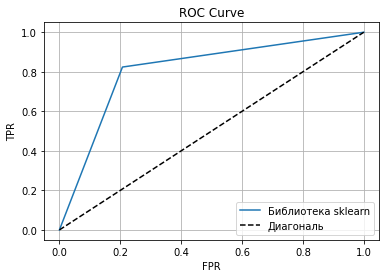

In [601]:
plt.plot(fpr, tpr, label = 'Библиотека sklearn')

# Добавляем диагональ под 45 градусов
plt.plot([0, 1], [0, 1], color='black', linestyle='dashed', label='Диагональ')

plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.grid()

**Выяислим значение ROC-AUC метрики.**

In [602]:
roc_auc_score(y_test, predictions)

0.8084096322683556

**Рассчитаем метрики TPR, FPR «вручную», без использования готовых функций из библиотеки sklearn.**

In [603]:
# Создаем список пороговых значений от 0 до 1 с шагом 0.01
thresholds = np.arange(0, 1.01, 0.01)
print(thresholds)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]


In [604]:
predictions = predictions[:100]
y_test = y_test[:100]
#y_test = y_test.to_numpy()

def check(X_test, y_test, treshold):
        
    tp1 = 0
    fp1 = 0
    tn1 = 0
    fn1 = 0
    
    pr1 = 0
    re1 = 0
    fpr1 = 0
    tpr1 = 0
    
    for predicted_prob, actual in zip( predictions, y_test ):
        if predicted_prob >= treshold:
            predicted = 1
        else:
            predicted = 0
            
        if predicted == 1:
            if actual == 1:
                tp1 += 1
            else:
                fp1 += 1
        else:
            if actual == 1:
                fn1 += 1
            else:
                tn1 += 1
                
        pr1 = tp1 / (tp1 + fp1 + 1e-09)
        re1 = tp1 / (tp1 + fn1 + 1e-09)
        tpr1 = tp1/(tn1 + fp1)
        fpr1 = fp1/(tn1 + fp1)
        
        
    return pr1, re1, fpr1, tpr1

In [605]:
fprs = []
tprs = []
prs = []
recs = []

for th in thresholds:
    precision_, recall_, fpr_, tpr_ =  check(X_test, y_test, th)
    fprs.append(fpr_)
    prs.append(precision_)
    recs.append(recall_)
    tprs.append(tpr_)

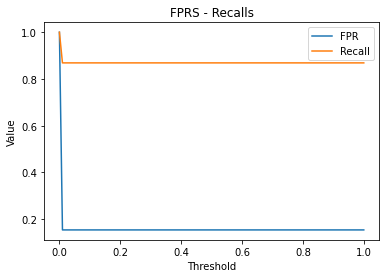

In [606]:
fig, ax = plt.subplots()

# Строим график FPRs
ax.plot(thresholds, fprs, label='FPR')

# Строим график Recalls
ax.plot(thresholds, recs, label='Recall')

# Настраиваем легенду и заголовки
ax.legend()
ax.set_xlabel('Threshold')
ax.set_ylabel('Value')
ax.set_title('FPRS - Recalls')

# Показываем график
plt.show()


**Построим ROC-кривую с помощью вычисленных вручную метрик FRP и TRP. Объединим графики метрик FRP и TRP рассчитанных вручную и с помощью библиотеки sklearn.**

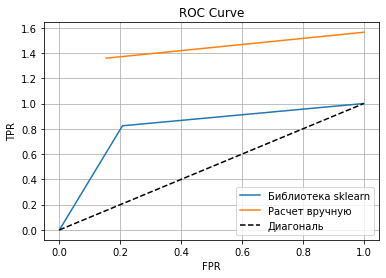

In [607]:
plt.plot(fpr, tpr, label = 'Библиотека sklearn')
plt.plot(fprs, tprs, label = 'Расчет вручную')

# Добавляем диагональ под 45 градусов
plt.plot([0, 1], [0, 1], color='black', linestyle='dashed', label='Диагональ')

plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.grid()


**Построим график Precision-Recall, используя показатели TP, FP и FN, рассчитанные вручную.**

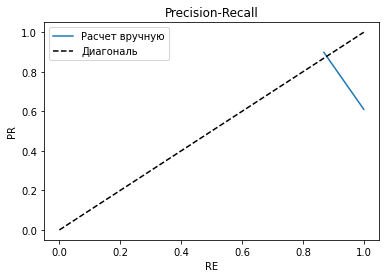

In [608]:
plt.plot(recs, prs, label = 'Расчет вручную')

# Добавляем диагональ под 45 градусов
plt.plot([0, 1], [0, 1], color='black', linestyle='dashed', label='Диагональ')

plt.legend()
plt.xlabel('RE')
plt.ylabel('PR')
plt.title('Precision-Recall')
plt.grid()
plt.grid()

**Вычислим значение ROC-AUC метрики, используя показатели TPR и FPR, рассчитанные вручную.**

In [609]:
auc(fprs, tprs)

1.2366863905325445

**Выводы.**

**1 - Как по полученным графикам сделать вывод о качестве модели? Как вы оцениваете обученную модель исходя из подсчитанных метрик?**
*Если линия ROC-кривой проходит близко к диагонали, это указывает на низкую эффективность модели. При этом более быстрый подъем кривой вверх указывает на лучшую производительность модели. При переобучении модели, линия ROC-кривой может находиться ниже диагонали.*

*Так как для нашей модели линия ROC-кривой находится выше диагонали и имеет большую скорость нарастания, можно сделать вывод, что она эффективна и не переобучена.*

**2 - Может ли ROC-кривая проходить ниже диагонали?**
*На основании полученных графиков, можно сделать вывод, что ROC-кривая не может проходить ниже диагонали, если она не переобучена.*